In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import ellip, lfilter, butter, find_peaks
from scipy.io import loadmat
import numpy as np
import h5py 

ModuleNotFoundError: No module named 'pandas'

## Generate Pulse Train by Delta Modulation

In [2]:
def delta_modulation_synced(inputSignal, ON_Threshold, OFF_Threshold):
    pulseTrain = np.zeros((2, 0))
    lastResetVoltage = 0
    for i in range(len(inputSignal)):
        diff = inputSignal[i] - lastResetVoltage
        if diff > ON_Threshold:
            num_pulse = np.floor_divide(diff,ON_Threshold).astype(int)
            pulseTrain = np.hstack((pulseTrain, np.vstack((i,num_pulse))))
            lastResetVoltage = lastResetVoltage + ON_Threshold * num_pulse
        elif diff < OFF_Threshold:
            num_pulse = np.floor_divide(diff,OFF_Threshold).astype(int)
            pulseTrain = np.hstack((pulseTrain, np.vstack((i,num_pulse * -1))))
            lastResetVoltage = lastResetVoltage + OFF_Threshold * num_pulse
    return pulseTrain

## Reconstruction of Signal based on Pulse Train

In [3]:
def LCADC_reconstruct(pulseTrain,Threshold):
    reconstructed_signal =  np.zeros([2,np.size(pulseTrain[0])])
    reconstructed_signal[0] = pulseTrain[0]
    reconstructed_signal[1][0] = 0
    for i in range(1,np.size(pulseTrain[0])):
            reconstructed_signal[1][i] = reconstructed_signal[1][i-1] + pulseTrain[1][i-1] * Threshold
    sig_length = np.max(pulseTrain[0]).astype(int)

    for j in range(sig_length+1):
        if j not in pulseTrain[0]:
            idx = np.where((reconstructed_signal[0] > j))
            idx = idx[0][0]
            reconstructed_signal = np.insert(reconstructed_signal,idx,[j,reconstructed_signal[1][idx]],axis=1)
    return reconstructed_signal

## Evaluation of Spike Detection

In [4]:
def evaluate_SPD(GT_spike_times, detected_spikeTimes, toleranceWindow, samplingInterval):
    trueDetection = 0
    falseDetection = 0
    missedDetection = 0
    halfToleranceWinSamples = int(toleranceWindow * 1e-3 / samplingInterval)  # tolerance +/- t ms
    spike_times_toleranceIncluded = np.concatenate([np.arange(gt - halfToleranceWinSamples, gt + halfToleranceWinSamples + 1) for gt in GT_spike_times])
    spike_times_toleranceIncluded = np.unique(spike_times_toleranceIncluded)
    
    trueDetection = np.sum(np.isin(detected_spikeTimes, spike_times_toleranceIncluded))
    falseDetection = len(detected_spikeTimes) - trueDetection
    
    spikeTimes_toleranceIncluded = np.concatenate([np.arange(dt - halfToleranceWinSamples, dt + halfToleranceWinSamples + 1) for dt in detected_spikeTimes])
    spikeTimes_toleranceIncluded = np.unique(spikeTimes_toleranceIncluded)
    
    missedDetection = np.sum(np.isin(GT_spike_times, spikeTimes_toleranceIncluded, invert=True))
    
    TP = trueDetection
    FP = falseDetection
    FN = missedDetection
    
    if TP == 0:
        return 0, 1, 0
    else:
        TPR = TP / (TP + FN)
        Sensitivity = TPR
        FDR = FP / (TP + FP)
        Accuracy = TP / (TP + FP + FN)
        return Sensitivity, FDR, Accuracy

## Load raw data file

In [2]:
MAT = loadmat('./Simulator_Data/C_Easy2_noise005.mat')
rawData = np.array(MAT['data'])[0]
spikeTimeGT = np.array(MAT['spike_times'])[0][0][0]
sampling_interval =np.array(MAT['samplingInterval'][0][0]) * 1e-3
sample_rate = 1/sampling_interval
data = rawData[0:int(sample_rate)]

NameError: name 'loadmat' is not defined

## Apply Filtering

(0.0, 24000.0)

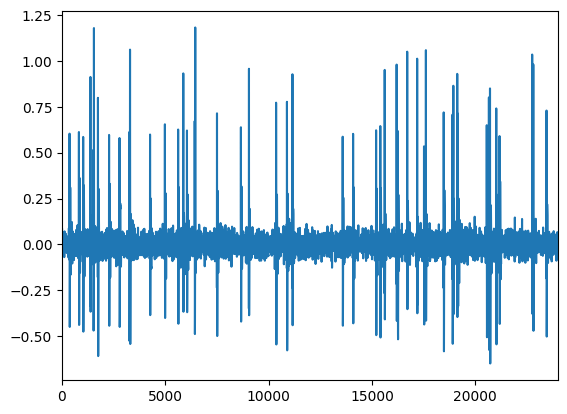

In [6]:
b, a = butter(4, [300*2/sample_rate, 5000*2/sample_rate], btype='band')
data = lfilter(b, a, data)
lim = [0,sample_rate]
plt.plot(data)
plt.xlim(lim)

## Determine Delta Modulation Threshold

In [9]:
def delta_mod_threshold_calc(data):
    # From the work of Quiroga et al "Unsupervised Spike Detection and Sorting with Wavelets and Superparamagnetic Clustering"
    ABS_THD = 4*np.median(np.abs(data) / 0.6745) # Amplitude Tresholding
    data_up = np.copy(data)
    data_up[data_up < ABS_THD] = 0
    peaks, _ = find_peaks(data_up)
    data_down = np.copy(data)
    data_down[data_down > -ABS_THD] = 0
    valleys, _ = find_peaks(abs(data_down))
    median_peak = np.median(data_up[peaks])
    median_valleys = np.median(data_down[valleys])
    spike_amplitude = (median_peak - median_valleys) / 2

    return ABS_THD, data_up, data_down, peaks, valleys, median_peak, median_valleys, spike_amplitude

Amplitude Threshold is: 0.18518728387190553


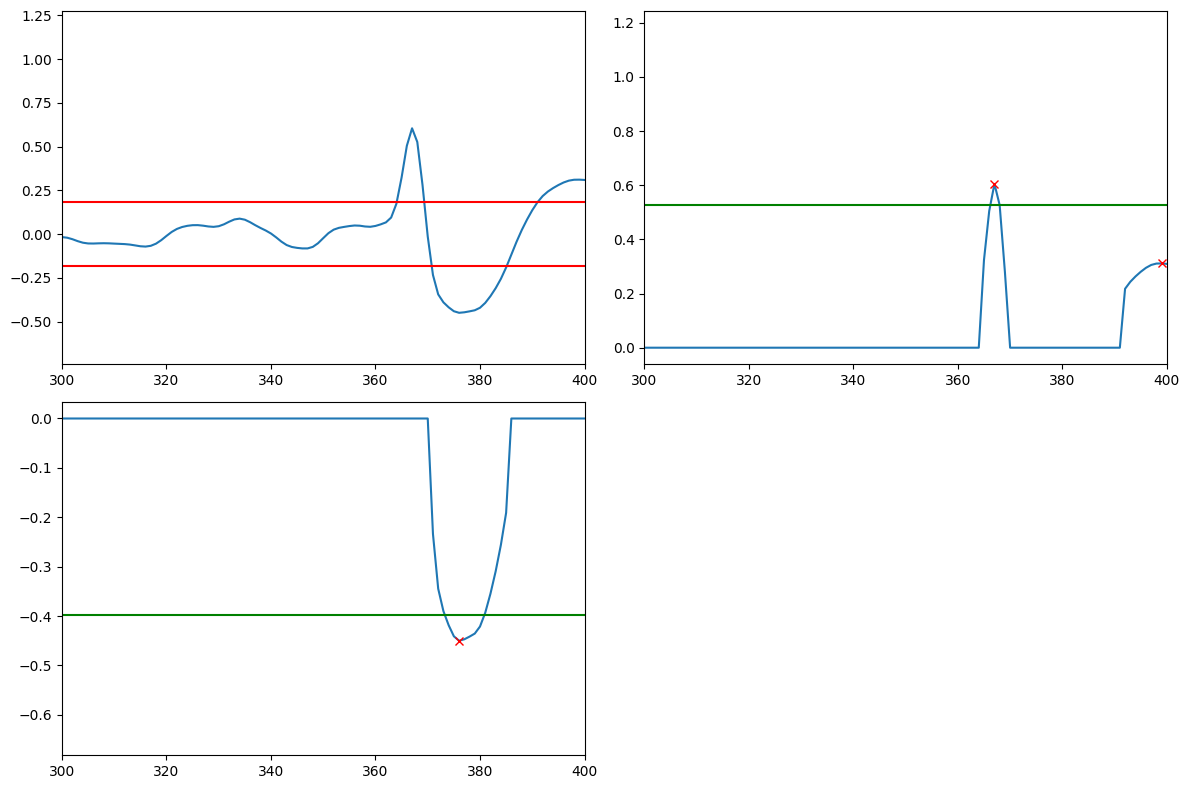

In [13]:
ABS_THD, data_up, data_down, peaks, valleys, median_peak, median_valleys, spike_amplitude = delta_mod_threshold_calc(data)
print(f"Amplitude Threshold is: {ABS_THD}")

plt.figure(figsize=(12, 8))

lim = [300, 400]

plt.subplot(221)
plt.plot(data)
plt.axhline(ABS_THD,color = 'r')
plt.axhline(-ABS_THD,color = 'r')
plt.xlim(lim)

plt.subplot(222)
plt.plot(data_up)
plt.plot(peaks, data_up[peaks], "x",color = 'r')
plt.axhline(median_peak,color = 'g')
plt.xlim(lim)

plt.subplot(223)
plt.plot(data_down)
plt.plot(valleys, data_down[valleys], "x",color = 'r')
plt.axhline(median_valleys,color = 'g')
plt.xlim(lim)

# plt.subplot(224)
# plt.stem(spikeTimeGT,np.ones(np.size(spikeTimeGT)))

plt.tight_layout()

## Plot ON/OFF events

Text(0, 0.5, 'Label')

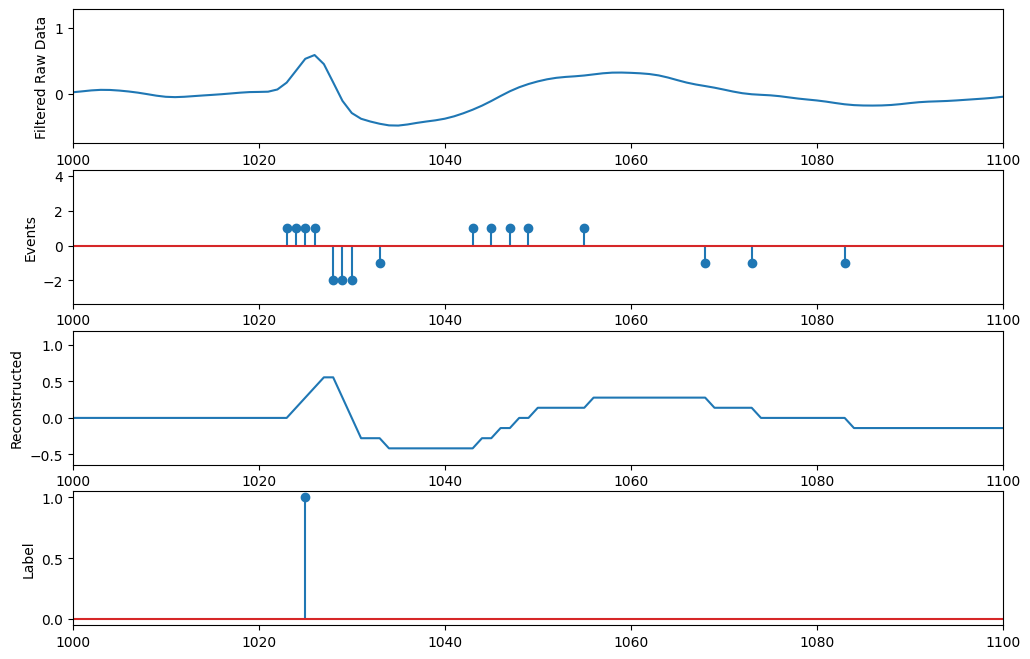

In [17]:
multiplier = 0.3
modulation_thd = spike_amplitude * multiplier

lim = [1000, 1100] # [300, 400] have a spike, [500, 600] have no spike, [1000, 1100] have no spike
ON_Threshold = modulation_thd
OFF_Threshold = -modulation_thd
pulseTrain = delta_modulation_synced(data, ON_Threshold, OFF_Threshold)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data)
plt.xlim(lim)
plt.ylabel("Filtered Raw Data")
plt.subplot(412)
plt.stem(pulseTrain[0], pulseTrain[1])
plt.xlim(lim)
plt.ylabel("Events")
sig = LCADC_reconstruct(pulseTrain,modulation_thd)
plt.subplot(413)
plt.plot(sig[0],sig[1])
plt.xlim(lim)
plt.ylabel("Reconstructed")
plt.subplot(414)
plt.stem(spikeTimeGT+20, np.ones(3410))
plt.xlim(lim)
plt.ylabel("Label")

## The pulse train for all of the files have been processed and saved as a .npy file for you to use

In [18]:
import os

In [19]:
def draw_figures(original_data, events, label, predict_data, single_label):
    ind_ = range(0, 800)

    fig, axs = plt.subplots(4, 1, layout='constrained')
    
    axs[0].stem(events[ind_])
    axs[0].set_ylabel("Events")

    axs[1].plot(label[ind_])
    axs[1].set_ylabel("Label")

    axs[2].plot(predict_data[ind_])
    axs[2].set_ylabel("Pred")

    axs[3].plot(single_label[ind_])
    axs[3].set_ylabel("Label_Vivek")

    plt.savefig("./test.jpg")
    plt.close()

In [20]:
def load_files_generate_spike_trains(filepath, filename, multiplier=0.3):
    # raw_data_file contains the following keys:
    # spike_class, spike_times, OVERLAP_DATA, data, chan, startData, samplingInterval
    raw_data_file = loadmat(os.path.join(filepath, filename + ".mat"))
    pulse_train = np.load(os.path.join(filepath, filename + ".npy"))

    data = np.array(raw_data_file['data'])[0]
    sampling_interval =np.array(raw_data_file['samplingInterval'][0][0]) * 1e-3
    sample_rate = 1/sampling_interval
    b, a = butter(4, [300*2/sample_rate, 6000*2/sample_rate], btype='band')
    data = lfilter(b, a, data)

    ABS_THD = 4*np.median(np.abs(data) / 0.6745)
    data_up = np.copy(data)
    data_up[data_up < ABS_THD] = 0
    peaks, _ = find_peaks(data_up)
    data_down = np.copy(data)
    data_down[data_down > -ABS_THD] = 0
    valleys, _ = find_peaks(abs(data_down))
    median_peak = np.median(data_up[peaks])
    median_valleys = np.median(data_down[valleys])
    spike_amplitude = (median_peak - median_valleys) / 2
    modulation_thd = spike_amplitude * multiplier

    ON_Threshold = modulation_thd
    OFF_Threshold = -modulation_thd
    spikeTimeGT = np.array(raw_data_file['OVERLAP_DATA'] > 0).astype(np.float32)
    data_len = spikeTimeGT.shape[1]
    spikeTimeGT = np.insert(spikeTimeGT, 0, [0 for _ in range(22)]) 
    spikeTimeGT = spikeTimeGT[:data_len].reshape(1, -1)

    spikeTimeGT_id = np.array(raw_data_file['spike_times'])[0][0][0] + 22

    return data, pulse_train, spikeTimeGT, sample_rate, spikeTimeGT_id

In [21]:
def load_synthetic_spike_data(filepath, filename):
    original_data, pulse_train, spikeTimeGT, sample_rate, spikeTimeGT_single = load_files_generate_spike_trains(filepath, filename)
    # After loading the data files, wee have the following:
    # Original data: The original unprocessed spikes
    # pulse_train: The post-processed delta-modulated spikes of dimension: 2*number_of_samples. index 0 is for time, index 1 is the actual delta modulated data
    # spikeTimeGT: The actual label in a window of dimension: 1*number_of_samples
    # sample_rate: The sample rate of the dataset. In the case of file: C_Burst_Easy2_noise015, it is 24000Hz.
    # spikeTimeGT_single: The actual label in a single time index manner

    spikeTimeGT = spikeTimeGT.squeeze(0)
    
    # spike_data_ind = (pulse_train[0]/10).astype(int).reshape(-1,1)
    spike_data_ind = (pulse_train[0]/10).astype(int)
    num_of_spikes = pulse_train[1]
    spikeTimeGT_single = spikeTimeGT_single.astype(int)
    spike = np.zeros_like(spikeTimeGT)
    for i, id in enumerate(spike_data_ind):
        spike[id] = num_of_spikes[i]

    label_single = np.zeros_like(spikeTimeGT)
    for i, id in enumerate(spikeTimeGT_single):
        label_single[id] = 1

    # draw_figures(original_data=original_data, events=spike, label=spikeTimeGT, predict_data=spikeTimeGT, single_label=label_single)

    return original_data, spike, spikeTimeGT, sample_rate, label_single